In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
columnsToNumeric = ["SeniorCitizen",
                    "Partner",
                    "Dependents",
                    "PhoneService",
                    "MultipleLines",
                    "OnlineSecurity",
                    "OnlineBackup",
                    "DeviceProtection",
                    "TechSupport",
                    "StreamingTV",
                    "StreamingMovies",
                    "PaperlessBilling",
                    "TotalCharges",
                    "Churn"] # Lista das colunas que terão seus tipos convertidos de object para numeric

categoricalColumns = ["gender", "Contract", "PaymentMethod"]
# Lista das colunas que vão passar pelo one-hot encoding

numericalColumns = ["tenure", "MonthlyCharges", "TotalCharges"]

In [3]:
categoricalColumns = ["gender", "Contract", "PaymentMethod"]
# Lista das colunas que vão passar pelo one-hot encoding

numericalColumns = ["tenure", "MonthlyCharges", "TotalCharges"]

pd.set_option('future.no_silent_downcasting', True)
# Evita warning de que função replace mude dados de forma automática (downcasting)

dataframe = pd.read_csv("customerchurn.csv")
# Definindo o Dataframe

scaler = StandardScaler()
# Definindo o StandardScaler para escalonar variáveis

In [4]:
dataframe["TotalCharges"] = pd.to_numeric(dataframe["TotalCharges"], errors="coerce")
# Converte os dados de TotalCharges para numéricos

In [5]:
for column in dataframe.columns:
    if dataframe[column].dtype == object:
        dataframe[column] = dataframe[column].str.strip()
        # Remove espaços em branco dos valores, cajo haja algum

        dataframe[column] = dataframe[column].replace({
            "No phone service": 0,
            "No": 0,
            "Yes": 1,
            "0": 0,
            "1": 1
        }) # Troca valores por 0 ou 1

In [6]:
dataframe.loc[dataframe["TotalCharges"].isnull(), "TotalCharges"] = 0
# Preenche as linhas de TotalCharges nulas com 0

In [7]:
for i in columnsToNumeric:
    dataframe[i] = pd.to_numeric(dataframe[i], errors="coerce")
    # Conversão de tipo para numeric

    if i != "TotalCharges":
        dataframe[i] = dataframe[i].astype(bool)
        # "Castando" as colunas para tipo bool (exceto TotalCharges)

In [8]:
dataframe = pd.get_dummies(dataframe, columns=categoricalColumns, drop_first=False)
# Aplica one-hot encoding para todas as colunas no categoricalColumns

internet_dummies = pd.get_dummies(dataframe["InternetService"], prefix="InternetService", drop_first=True)
# Aplica one-hot encoding apenas para a coluna InternetService, descartando a primeira coluna (No)

dataframe = pd.concat([dataframe, internet_dummies], axis=1)
# Adiciona as colunas dummies (one-hot encoding) no dataframe

dataframe.drop(columns=["InternetService"], inplace=True)
# Remove a coluna original do dataframe, deixando apenas as que passaram pelo one-hot encoding

dataframe[numericalColumns] = scaler.fit_transform(dataframe[numericalColumns])
# Escalonamento de variáveis

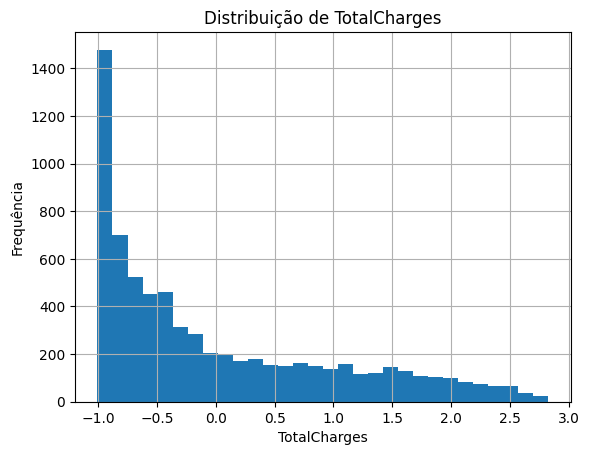

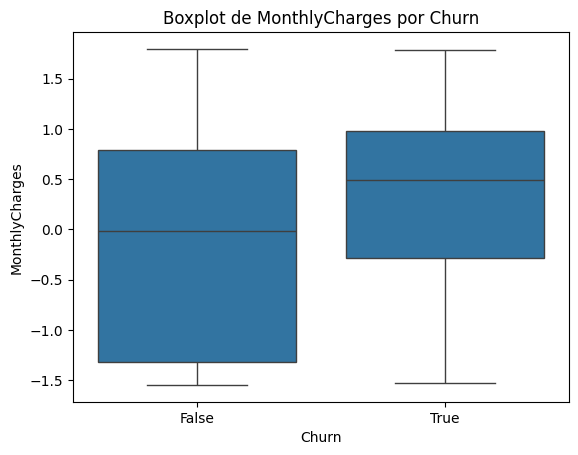

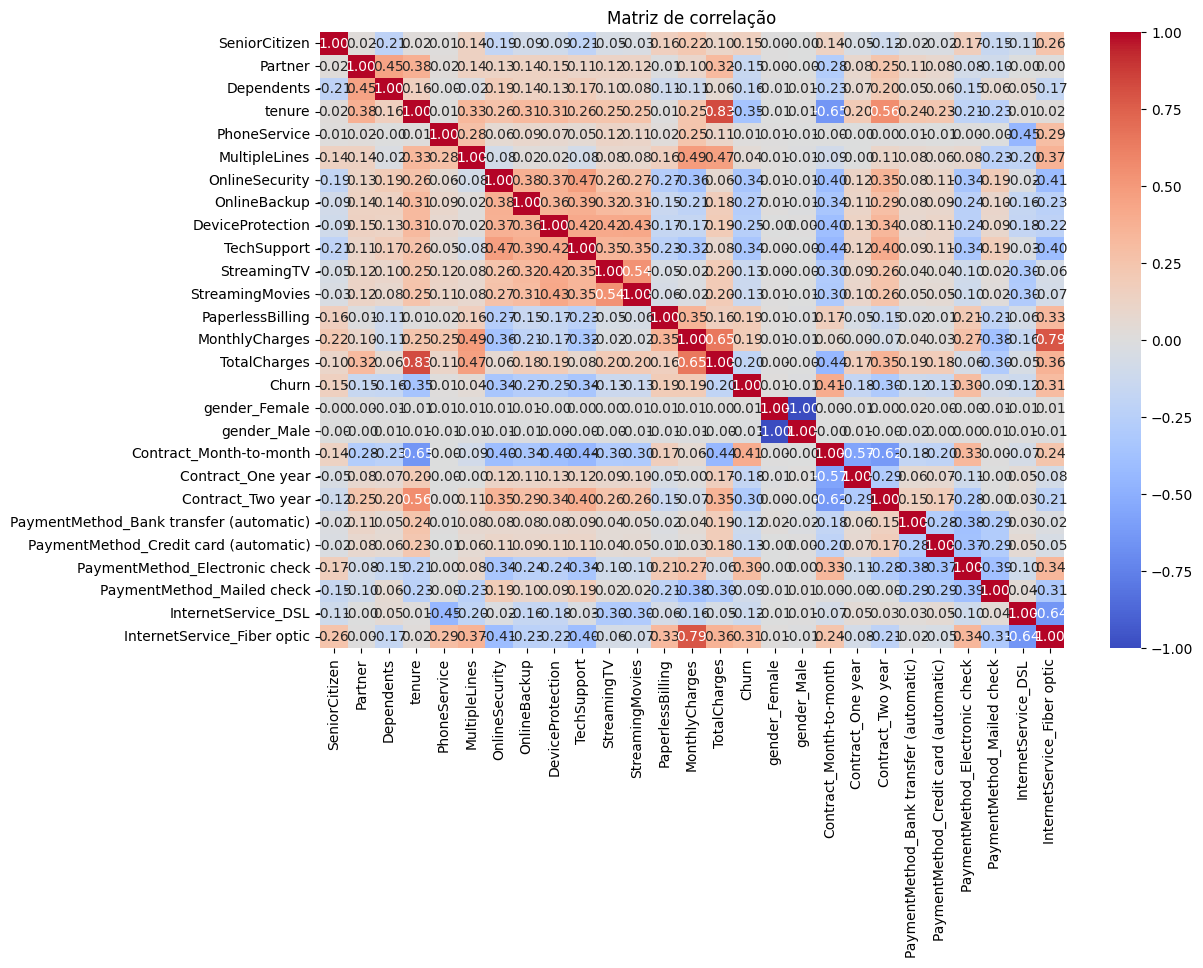

In [9]:
dataframe["TotalCharges"].hist(bins=30)
plt.title("Distribuição de TotalCharges")
plt.xlabel("TotalCharges")
plt.ylabel("Frequência")
plt.show()
# Histograma

sb.boxplot(x="Churn", y="MonthlyCharges", data=dataframe)
plt.title("Boxplot de MonthlyCharges por Churn")
plt.show()
# Boxplot

plt.figure(figsize=(12,8))
sb.heatmap(dataframe.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlação")
plt.show()

# Matriz de correlação

In [10]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# -- Seleção de Melhores Atributos via SelectKBest --- 
print("\n--- Seleção de Features com SelectKBest ---")

# Separa as features (X) da variável alvo (y)
# 'customerID' é removido pois não é uma feature de treinamento
X = dataframe.drop(columns=['Churn', 'customerID'], errors='ignore')
y = dataframe['Churn']

# Seleciona as 20 melhores features
k_best = 20
selector = SelectKBest(score_func=f_classif, k=k_best)
X_best = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"As {k_best} melhores features selecionadas são:")


--- Seleção de Features com SelectKBest ---
As 20 melhores features selecionadas são:



--- Visualização 2D com PCA ---


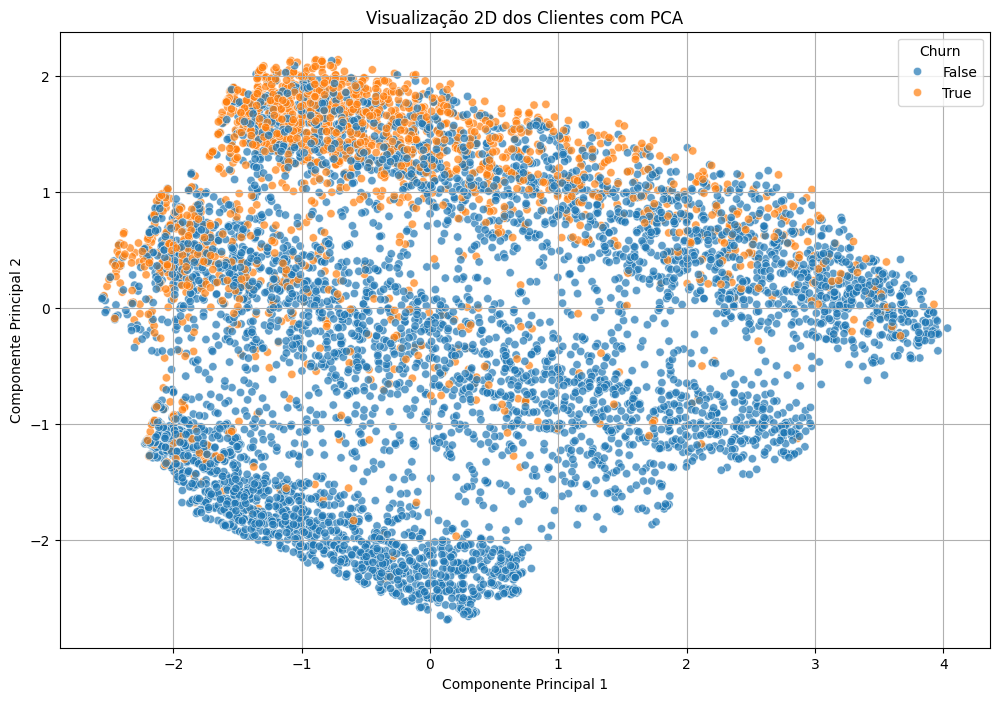

In [11]:
# --- Aplicação de PCA para Visualização 2D --- 
print("\n--- Visualização 2D com PCA ---")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X) # Usa o conjunto X completo

pca_df = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
pca_df['Churn'] = y.values

plt.figure(figsize=(12, 8))
sb.scatterplot(x='Componente Principal 1', y='Componente Principal 2', hue='Churn', data=pca_df, alpha=0.7)
plt.title('Visualização 2D dos Clientes com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Churn')
plt.grid()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.base import is_classifier

# --- Dividir em treino e teste (80%/20%) ---
print("\n--- Divisão em Treino e Teste ---")
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42, stratify=y)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")


--- Divisão em Treino e Teste ---
Shape de X_train: (5634, 20)
Shape de X_test: (1409, 20)
Shape de y_train: (5634,)
Shape de y_test: (1409,)


In [13]:
# --- Instânciamento dos modelos ---
dt_model = DecisionTreeClassifier(random_state=42)  # Arvore de Decisão
svm_model = SVC(random_state=42, probability=True) # SVM
mlp_model = MLPClassifier(random_state=42, max_iter=2000) # MLP Rede Neural

# Definir os parâmetros para GridSearchCV para cada modelo
# Parâmetros da Árvore de Decisão
param_grid_dt = {
    'max_depth': [3, 5],
    'min_samples_leaf': [5, 10]
}
# Parâmetros do SVM
param_grid_svm = {
    'C': [1],
    'kernel': ['rbf']
}
# Parâmetros do MLP Rede Neural
param_grid_mlp = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'alpha': [0.001]
}

In [14]:
# --- Função para Calcular ROC-AUC ---
def roc_auc_scoring_function(estimator, X, y_true):
    # É necessário as probabilidades do modelo para criar a ROC-AUC
    # Verifica se o modelo tem 'predict_proba'
    if hasattr(estimator, 'predict_proba') and is_classifier(estimator):
        y_proba = estimator.predict_proba(X)[:, 1]
    else:
        # Se não existir 'predict_proba', usamos a 'decision_function'
        print("Aviso: predict_proba não disponivel")
        y_proba = estimator.predict(X)
    return roc_auc_score(y_true, y_proba)

# Agrupando modelos e seus parâmetros para o GridSearch
models_to_tune = {
    'Decision Tree': {'model': dt_model, 'params': param_grid_dt},
    'SVM': {'model': svm_model, 'params': param_grid_svm},
    'MLP': {'model': mlp_model, 'params': param_grid_mlp}
}

# Dicionário para apenas guardar o melhor modelo de cada tipo após o ajuste
best_models = {}

In [15]:
# --- Realizar GridSearchCV para Ajuste de Hiperparâmetros ---
print("\n--- Ajuste de Hiperparâmetros com GridSearchCV ---")
for name, config in models_to_tune.items():
    print(f"\nSintonizando o modelo: {name}...")
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring=roc_auc_scoring_function, verbose=1)
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"\n - Melhores parâmetros para {name}: {grid_search.best_params_}")
    print(f" - Melhor pontuação ROC-AUC para {name} no treino (Validação Cruzada): {grid_search.best_score_:.4f}")
print("\nTodos os modelos foram sintonizados.")


--- Ajuste de Hiperparâmetros com GridSearchCV ---

Sintonizando o modelo: Decision Tree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

 - Melhores parâmetros para Decision Tree: {'max_depth': 5, 'min_samples_leaf': 5}
 - Melhor pontuação ROC-AUC para Decision Tree no treino (Validação Cruzada): 0.8259

Sintonizando o modelo: SVM...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

 - Melhores parâmetros para SVM: {'C': 1, 'kernel': 'rbf'}
 - Melhor pontuação ROC-AUC para SVM no treino (Validação Cruzada): 0.7951

Sintonizando o modelo: MLP...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

 - Melhores parâmetros para MLP: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
 - Melhor pontuação ROC-AUC para MLP no treino (Validação Cruzada): 0.8136

Todos os modelos foram sintonizados.



--- Avaliação dos Modelos no Conjunto Teste ---

--- Avaliando o modelo: Decision Tree ---

 - Matriz de Confusão:
[[913 122]
 [162 212]]


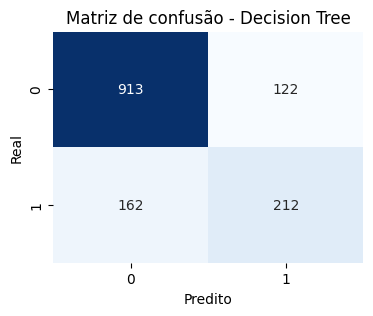

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.85      0.88      0.87      1035
        True       0.63      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.8291


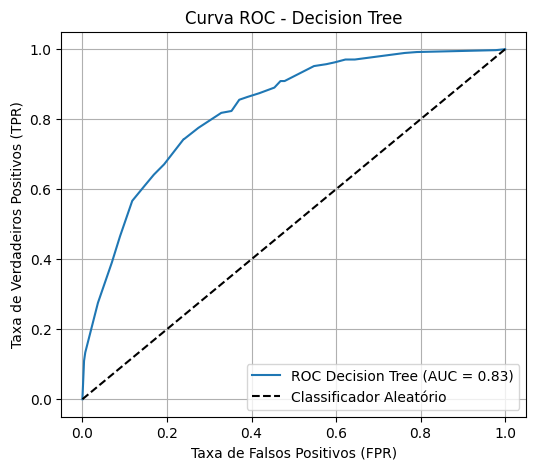


--- Avaliando o modelo: SVM ---

 - Matriz de Confusão:
[[931 104]
 [181 193]]


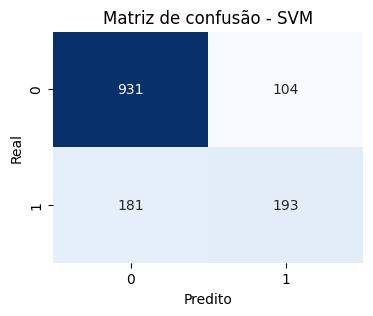

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      1035
        True       0.65      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.7976


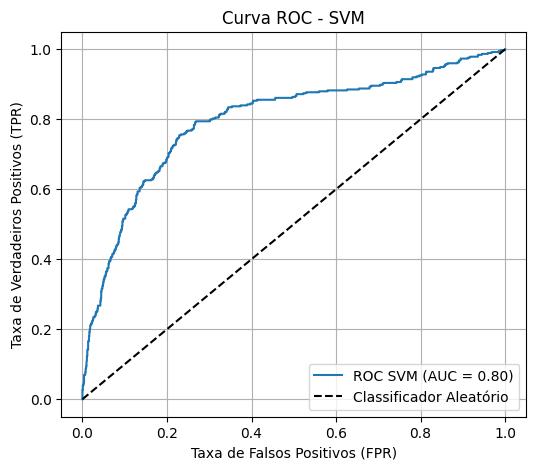


--- Avaliando o modelo: MLP ---

 - Matriz de Confusão:
[[889 146]
 [178 196]]


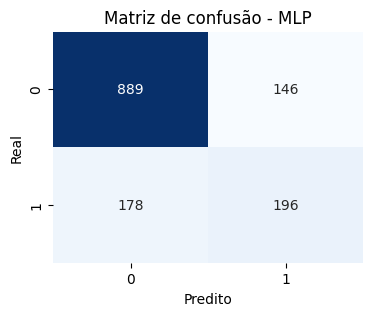

Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.83      0.86      0.85      1035
        True       0.57      0.52      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409

ROC-AUC: 0.8158


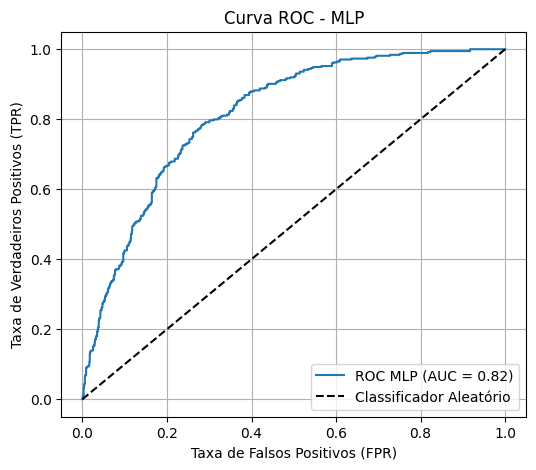


Analisando as pontuações ROC-AUC no conjunto de teste:

 --- Análise Concluída ---
 - Decision Tree: ROC-AUC = 0.8291
 - SVM: ROC-AUC = 0.7976
 - MLP: ROC-AUC = 0.8158
 -------------------------


In [16]:
# --- Avaliar Desempenho no Conjunto de Teste ---
print("\n--- Avaliação dos Modelos no Conjunto Teste ---")
results = {}

for name, model in best_models.items():
    print(f"\n--- Avaliando o modelo: {name} ---")
    y_pred = model.predict(X_test) # Faz as previsões binárias

    # Obtem as probabilidades (scores) para a curva ROC e o ROC-AUC
    if hasattr(model, 'predict_proba'):
        # Probabilidade da classe positiva
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        #Score de decisão para SVM sem probabilidade=True
        y_proba = model.decision_function(X_test)
        print(f"Aviso: {name} nâo tem predict_proba. Usando 'decision_function' para a curva ROC.")

    # --- Matriz de Confusão ---
    cm = confusion_matrix(y_test, y_pred)
    print("\n - Matriz de Confusão:")
    print(cm)
    plt.figure(figsize=(4, 3)) # Tamanho menor para a matriz de confusão
    sb.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', cbar=False) # cbar=False para remover a barra de cores
    plt.title(f'Matriz de confusão - {name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    # --- Precision, Recall, F1-Score ---
    report = classification_report(y_test, y_pred)
    print("Relatório de Classificação:")
    print(report)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba) # Usamos a probabilidade para o melhor detalhamento
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Plotar Curvar ROC
    plt.figure(figsize=(6, 5))

    # Calcula a True Positive Rate (TPR) e False Positive Rate (FPR)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    # Plota a curva ROC
    plt.plot(fpr, tpr, label=f'ROC {name} (AUC = {roc_auc:.2f})')

    # Plota a linha de base (classificados aleatório)
    plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curva ROC - {name}')
    plt.legend(loc='lower right') # Posição da legenda
    plt.grid(True) # Adiciona uma grade no gráfico
    plt.show() # Mostra o gráfico

    results[name] = { # Armazena os resultados para um comparativo final
        'Matriz de Confusão': cm,
        'Relatório de Classificação': report,
        'ROC-AUC': roc_auc
    }

# Comparativo Final dos Modelos
print("\nAnalisando as pontuações ROC-AUC no conjunto de teste:")
print("\n --- Análise Concluída ---")
for name, res in results.items():
    print(f" - {name}: ROC-AUC = {res['ROC-AUC']:.4f}")
print(" -------------------------")